# 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from sklearn.metrics import mean_absolute_error,mean_squared_error
import pickle
from sklearn.model_selection import train_test_split
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings(action='ignore')
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
%matplotlib inline

# 데이터로드

In [2]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
forward_df = fm_data_df[fm_data_df['포지션']=='공격수']
forward_df = forward_df.reset_index(drop=True)

# 데이터 EDA

## 모델 생성에 사용할 독립변수, 종속변수 선별

In [3]:
num_col = [forward_df.columns[i] for i,x in enumerate(forward_df.dtypes) if x == 'int64' or x == 'float64']
independent_value = set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90'])
dependent_value = '평균획득승점/경기'

## 결측치 확인

In [4]:
forward_df.isna().sum()

이름              0
포지션             0
골               0
도움              0
경기당 팀 득점/90     0
경기당 팀 실점/90     0
크로스 성공률         0
파울 획득           0
반칙 수/90         0
기회 창출/90        0
경기당 유효 슈팅/90    0
경기당 슈팅/90       0
인터셉트/90         0
달린 거리/90분       0
공중볼시도/90        0
태클 성공률          0
경기당 패스 시도/90    0
경기당 패스 성공/90    0
키패스/90          0
태클 성공/90        0
드리블 성공/90       0
헤더 성공/90        0
크로스 시도/90       0
평균획득승점/경기       0
시즌              0
dtype: int64

## 변수 군집화

### 패스 군집화

In [5]:
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.metrics import silhouette_score

k : 2 , score: 5510.071934917474
k : 3 , score: 3260.4705302122416
k : 4 , score: 2275.6500080856827
k : 5 , score: 1501.7584442308678
k : 6 , score: 1112.5214742660937
k : 7 , score: 855.1222766000275
k : 8 , score: 679.3124567879726
k : 9 , score: 572.1171083690101


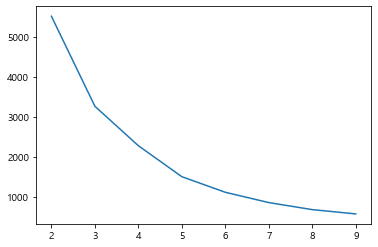

In [6]:
k_range = range(2,10)
inertia_arr = []

for k in k_range:
    kmeans = KMeans(n_clusters=k,random_state=123)
    kmeans.fit(list(zip(forward_df['경기당 패스 성공/90'],forward_df['경기당 패스 시도/90'])))
    inertia = kmeans.inertia_

    print(f'k : {k} , score: {inertia}')
    
    inertia_arr.append(inertia)
    
plt.plot(k_range,inertia_arr)

In [7]:
pass_kmeans = KMeans(n_clusters=3,random_state=123).fit(list(zip(forward_df['경기당 패스 성공/90'],forward_df['경기당 패스 시도/90'])))

forward_df['패스군집'] = pass_kmeans.predict(list(zip(forward_df['경기당 패스 성공/90'],forward_df['경기당 패스 시도/90'])))

forward_df['패스군집_이름'] = forward_df['패스군집'].map(lambda x : '일반패스군' if x == 0 else ('안전패스군' if x == 1 else '위험패스군'))

<AxesSubplot:xlabel='경기당 패스 성공/90', ylabel='경기당 패스 시도/90'>

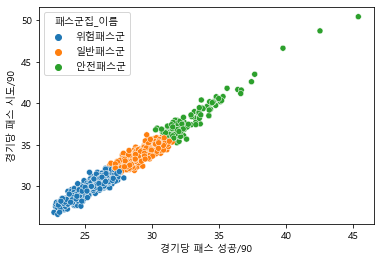

In [8]:
sns.scatterplot(x='경기당 패스 성공/90',y='경기당 패스 시도/90',data=forward_df,hue='패스군집_이름')

In [9]:
independent_value = independent_value - set(['경기당 패스 성공/90','경기당 패스 시도/90'])

In [10]:
safe_pass_df = forward_df[forward_df['패스군집_이름']=='안전패스군']
normal_pass_df = forward_df[forward_df['패스군집_이름']=='일반패스군']
danger_pass_df = forward_df[forward_df['패스군집_이름']=='위험패스군']

# 패스 군집별 모델 생성

In [11]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold

def gridsearch_by_cluster(df):
    forward_lgbm = LGBMRegressor()

    params = {
        'num_leaves': [5,10,15,20,25,30],
        'learning_rate': [0.01,0.1,0.2],
        'n_estimators':[100],
        'max_depth': [-1],
        'objective' : ["regression",'huber'],
        'random_state' :[123],
        'reg_alpha' : [1.1,1.2,1.3,1.4,1.5],
        'reg_lambda' : [1.1,1.2,1.3,1.4,1.5],
        'subsample': [0.5,0.6,0.7,0.8,0.9,1.0],
        'extra_trees' : [True]
    }


    grid = GridSearchCV(forward_lgbm, params, scoring='neg_mean_absolute_error', cv=5,refit=True)

    grid.fit(df.loc[:,independent_value],
             df.loc[:,dependent_value])

    print(grid.best_score_)
    print(grid.best_estimator_)
    print(grid.best_params_)
    
    return grid

## LGBM Regressor 안전패스군 모델 생성

In [12]:
gridsearch_by_cluster(safe_pass_df)

-0.2757054103880132
LGBMRegressor(extra_trees=True, learning_rate=0.2, num_leaves=5,
              objective='regression', random_state=123, reg_alpha=1.3,
              reg_lambda=1.1, subsample=0.5)
{'extra_trees': True, 'learning_rate': 0.2, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 5, 'objective': 'regression', 'random_state': 123, 'reg_alpha': 1.3, 'reg_lambda': 1.1, 'subsample': 0.5}


GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'extra_trees': [True],
                         'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [-1],
                         'n_estimators': [100],
                         'num_leaves': [5, 10, 15, 20, 25, 30],
                         'objective': ['regression', 'huber'],
                         'random_state': [123],
                         'reg_alpha': [1.1, 1.2, 1.3, 1.4, 1.5],
                         'reg_lambda': [1.1, 1.2, 1.3, 1.4, 1.5],
                         'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             scoring='neg_mean_absolute_error')

In [13]:
safe_forward_lgbm = LGBMRegressor(
                num_leaves=5,
                learning_rate=0.2,
                max_depth=-1,
                n_estimators=100,
                objective='regression',
                random_state=123,
                reg_alpha=1.3,
                reg_lambda=1.1,
                subsample=0.5,
                extra_trees=True
                )

In [14]:
safe_x_train,safe_x_test,safe_y_train,safe_y_test = train_test_split(safe_pass_df.loc[:,independent_value],safe_pass_df.loc[:,dependent_value],test_size=0.2)

In [15]:
safe_forward_lgbm.fit(safe_x_train,safe_y_train)

LGBMRegressor(extra_trees=True, learning_rate=0.2, num_leaves=5,
              objective='regression', random_state=123, reg_alpha=1.3,
              reg_lambda=1.1, subsample=0.5)

In [16]:
safe_y_pred = safe_forward_lgbm.predict(safe_x_test)
mean_absolute_error(safe_y_test,safe_y_pred)

0.24496386491849087

### 데이터 삽입

In [17]:
forward_df['predict'] = 0

safe_pass_df['predict'] = safe_forward_lgbm.predict(safe_pass_df.loc[:,independent_value])

safe_index = safe_pass_df.loc[:,independent_value].index

forward_df.loc[safe_index,'predict'] = safe_forward_lgbm.predict(safe_pass_df.loc[:,independent_value])

## LGBM Regressor 일반패스군 모델 생성

In [18]:
gridsearch_by_cluster(normal_pass_df)

-0.3172677694512983
LGBMRegressor(extra_trees=True, num_leaves=5, objective='regression',
              random_state=123, reg_alpha=1.2, reg_lambda=1.1, subsample=0.5)
{'extra_trees': True, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 5, 'objective': 'regression', 'random_state': 123, 'reg_alpha': 1.2, 'reg_lambda': 1.1, 'subsample': 0.5}


GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'extra_trees': [True],
                         'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [-1],
                         'n_estimators': [100],
                         'num_leaves': [5, 10, 15, 20, 25, 30],
                         'objective': ['regression', 'huber'],
                         'random_state': [123],
                         'reg_alpha': [1.1, 1.2, 1.3, 1.4, 1.5],
                         'reg_lambda': [1.1, 1.2, 1.3, 1.4, 1.5],
                         'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             scoring='neg_mean_absolute_error')

In [19]:
normal_forward_lgbm = LGBMRegressor(
                num_leaves=5,
                learning_rate=0.1,
                max_depth=-1,
                objective='regression',
                random_state=123,
                reg_alpha=1.2,
                reg_lambda=1.1,
                subsample=0.5,
                extra_trees=True
                )

In [20]:
normal_x_train,normal_x_test,normal_y_train,normal_y_test = train_test_split(normal_pass_df.loc[:,independent_value],normal_pass_df.loc[:,dependent_value],test_size=0.2,random_state=123)

In [21]:
normal_forward_lgbm.fit(normal_x_train,normal_y_train)

LGBMRegressor(extra_trees=True, num_leaves=5, objective='regression',
              random_state=123, reg_alpha=1.2, reg_lambda=1.1, subsample=0.5)

In [22]:
normal_y_pred = normal_forward_lgbm.predict(normal_x_test)
mean_absolute_error(normal_y_test,normal_y_pred)

0.3187204816626354

In [23]:
normal_pass_df['predict'] = normal_forward_lgbm.predict(normal_pass_df.loc[:,independent_value])

In [24]:
normal_index = normal_pass_df.loc[:,independent_value].index

In [25]:
forward_df.loc[normal_index,'predict'] = normal_forward_lgbm.predict(normal_pass_df.loc[:,independent_value])

# 위험 패스군 모델 생성

In [26]:
gridsearch_by_cluster(danger_pass_df)

-0.25953940364196715
LGBMRegressor(extra_trees=True, learning_rate=0.2, num_leaves=5,
              objective='regression', random_state=123, reg_alpha=1.2,
              reg_lambda=1.5, subsample=0.5)
{'extra_trees': True, 'learning_rate': 0.2, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 5, 'objective': 'regression', 'random_state': 123, 'reg_alpha': 1.2, 'reg_lambda': 1.5, 'subsample': 0.5}


GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'extra_trees': [True],
                         'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [-1],
                         'n_estimators': [100],
                         'num_leaves': [5, 10, 15, 20, 25, 30],
                         'objective': ['regression', 'huber'],
                         'random_state': [123],
                         'reg_alpha': [1.1, 1.2, 1.3, 1.4, 1.5],
                         'reg_lambda': [1.1, 1.2, 1.3, 1.4, 1.5],
                         'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             scoring='neg_mean_absolute_error')

In [81]:
danger_forward_lgbm = LGBMRegressor(
                num_leaves=10,
                learning_rate=0.2,
                max_depth=5,
                n_estimators=100,
                objective='regression',
                random_state=123,
                reg_alpha=1.2,
                reg_lambda=1.4,
                subsample=0.5,
                extra_trees=True
                )

In [82]:
danger_x_train,danger_x_test,danger_y_train,danger_y_test = train_test_split(danger_pass_df.loc[:,independent_value],danger_pass_df.loc[:,dependent_value],test_size=0.2,random_state=123)

In [83]:
danger_forward_lgbm.fit(danger_x_train,danger_y_train)

LGBMRegressor(extra_trees=True, learning_rate=0.2, max_depth=5, num_leaves=10,
              objective='regression', random_state=123, reg_alpha=1.2,
              reg_lambda=1.4, subsample=0.5)

In [84]:
danger_y_pred = danger_forward_lgbm.predict(danger_x_test)
mean_absolute_error(danger_y_test,danger_y_pred)

0.2768411665197937

In [85]:
danger_pass_df['predict'] = danger_forward_lgbm.predict(danger_pass_df.loc[:,independent_value])

In [86]:
danger_index = danger_pass_df.loc[:,independent_value].index

In [87]:
forward_df.loc[danger_index,'predict'] = danger_forward_lgbm.predict(danger_pass_df.loc[:,independent_value])

In [88]:
import joblib

joblib.dump(safe_forward_lgbm, './models/forward/safe_forward_lgbm.pkl')
joblib.dump(normal_forward_lgbm, './models/forward/normal_forward_lgbm.pkl')
joblib.dump(danger_forward_lgbm, './models/forward/danger_forward_lgbm.pkl')
joblib.dump(pass_kmeans, './models/forward/forward_pass_kmeans.pkl')

['./models/forward/forward_pass_kmeans.pkl']

## 잔차의 정규성 검정

In [91]:
# 정규성 불만족
stats.shapiro(residual)

ShapiroResult(statistic=0.995090663433075, pvalue=0.003174541285261512)

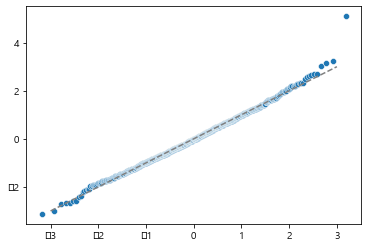

In [92]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

## 잔차의 등분산성 검정

<AxesSubplot:xlabel='predict'>

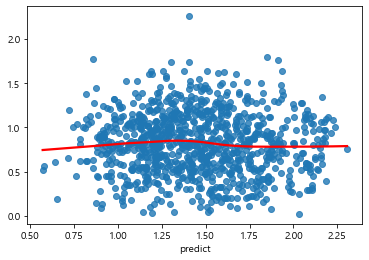

In [93]:
sns.regplot(forward_df['predict'], np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})

In [94]:
# 등분산성 불만족
stats.levene(forward_df['평균획득승점/경기'],forward_df['predict'])

LeveneResult(statistic=100.05115790199757, pvalue=5.300429952854963e-23)

## 잔차의 독립성 검정

In [95]:
from statsmodels.stats.stattools import durbin_watson

# 독립성 불만족
durbin_watson(residual)

1.2940596905801485

In [97]:
mean_absolute_error(forward_df['평균획득승점/경기'],forward_df['predict'])

0.23162944174486666

In [100]:
np.sqrt(mean_squared_error(forward_df['평균획득승점/경기'],forward_df['predict']))

0.2917931302780201